#EECS 2025 Lecture 6: Introduction to Markov Processes

In the last lecture, the state was an arbitrary vector, perhaps representing the position and velocity of a physical system.  In some sense, each combination of values of (position, velocity) is a different state.  If we could count these states, then we could number them in some way, perhaps labeled with integers, and we could ask how likely it is that state $i$ would be followed by state $j$.   In particular, we could ask for the "transition probabilities" $p(i\rightarrow j)$ which we can write as $p_{ji}$ for short (note the change of order of the indices).  This can be represented in a matrix $M = [p_{ji}]$ where the $i$'th column of $M$ is the probability that each state $j$ is next given that the last state was $i$.  Since you have to go to one of the possible states, the sum $\sum_j p_{ji} = 1$, meaning that the column sums of $M$ are all 1.  In that case we call $M$ a "stochastic matrix" or a "Markov matrix".

Looking at this the other way, we can ask what is the chance that we end up in state $j$ at a particular time?  Well, that depends on the proability of being in each possible prior state $i$, and the chance you will get to $j$. In other words, $prob(j) = \sum_i p_{ji}prob(i)$, because those are all the possible ways of getting to $j$.  Looking at this as a matrix, if we have a vector $p_j$ where each element is the probability of being in one state $j$, and another vector $p_i$, then we can write
\begin{equation}
  p_j = M p_i
\end{equation}
or, more generally if $i(t)$ is the value of the state at time $t$, and $p(t)$ is a vector indicating the probability of being in each state at time $t$, then
\begin{equation}
  p(t+1) = M p(t)
  \end{equation}
Which is the Markov update equation.  

Why do we use the term "Markov"?  Because Andrey Markov figured this out 100 years ago.  A "Markov Process" is a process that depends only on a finite history.  In this case, the current state depends only on the past state, so one step back.  But it's ok to be multiple steps back (remember "predict_length"?) but you can't go infinitely far back.

What about going forward?  Well it should be clear that
\begin{equation}
  p(t+N) = M^N p(t)
\end{equation}
So we can iterate.  The largest eigenvalue of Markov matrices is 1, and this eigenvalue is (almost) always unique, which allows us to prove:
\begin{equation}
  \lim_{t\rightarrow \infty} p(t) = M_{\infty} p(0)
  \end{equation}
where $M_{\infty} = \lim_{t\rightarrow \infty} M^t$, and all the columns of $M_{\infty}$ are equal to the eigenvector of $M$ with maximal eigenvalue (which is 1).  In other words, no matter where you start, you always end up at the same place.

From the point of view of timeseries, Markov matrices are representations of the dynamics of discrete-state systems (there is a continuous version, but of course all real computer-based systems are discrete).  We can force a Keras/Tensorflow SimpleRNN to look like a Markov update rule by using the "softmax" activation function.

In the following, I will show you how to implement Markov processes in Keras.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

import tensorflow as tf

#for your homework
np.random.seed(57999719)
tf.random.set_seed(57999719)

array([ 4,  5,  6,  7,  8,  9,  9, 10,  9, 10])

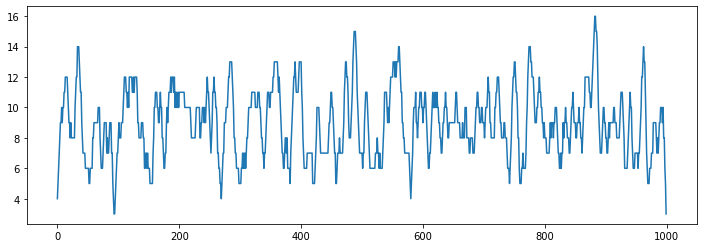

In [ ]:
#generate an artificial dataset of discrete state values
#here is the random number generator
from numpy.random import default_rng
rng = default_rng()
time_points = 1000
random_signal = rng.random(time_points)  #values in 0...1
FIR_filter = [1,2,3,3,4,3,3,2,1]    #smoothing filter so there is some predictability to the sequence
FIR_filter = FIR_filter / np.sum(FIR_filter)
filtered_signal = np.convolve(random_signal, FIR_filter, 'same') #if use convolution mode:'same' will not line up
n_states = 20
state_sequence = n_states*filtered_signal
state_sequence = state_sequence.astype(int)
plt.figure(figsize=(12,4), linewidth = 1)
plt.plot(state_sequence);
state_sequence[0:10]

We need to convert these integer values into probabilities of state.  Because we know each integer, the probability vector will have a 1 corresponding to the known correct answer, and 0 for each of the other (incorrect) answers.  Thus we change every value $i$ into a probability vector $P[x=i]$, which is a vector with a single value of 1 for the correct answer.  Of course, the sum of the vector is 1 so this is a valid probability.

In [ ]:
#encode the state in a state vector representing the probabilities.  These are the actual measured states, so prob=1 for the correct state
state_vec = np.zeros((time_points, n_states), dtype = int)
state_vec[np.arange(time_points),state_sequence] = 1
state_vec[0:10,:]

array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
#make a dataframe out of this.
#   remember that dataframes look like spreadsheets.
state_df = pd.DataFrame(data=state_vec, index=np.arange(time_points))
state_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
predict_length = 1
generator = TimeseriesGenerator(state_df.values, state_df.values, length =predict_length , batch_size=1)  #use at least 14 points because 14 dimensions
#NOTE1:  you have to use df.values or you get weird indexing errors
generator[0]

(array([[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]]),
 array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

so you can see how the integers have been "promoted" to probability vectors, and the timeseries generator generates a single vector as input and a single vector as output, corresponding to $p(t)$ and $p(t+1)$ vectors.

#TimeSeriesGenerator for multivariate data passed to an RNN





When working with probabilties, we often use the softmax activation function.  The main purpose of this function is to enforce that the output vector is a valid probability; in other words, all the values at the output have to sum to 1.  But there is some good mathematics behind this that I won't go into right now.  I do want to explain the computation value of softmax, which follows:

The softmax activation function is given by
\begin{equation}
 \sigma(x_i) = \frac{e^{x_i}}{\sum_i e^{x_i}}
 \end{equation}
In other words, exponentiates its input, then normalizes so the sum is 1.  The normalization allows this to look like a probability density, because if we interpret the outputs as probabilities $p_i$ then $\sum p_i = 1$.

But why the exponential?  If the output is a probability, then the input is a log probability (sometimes called log-odds meaning that it is the log of the ratio of the chance of something being true to the probability that it would be false).  Here, the important fact is that when you sum two log probabilities, you multiply the probabilities.  So if the input to a softmax unit $x_i(t)$ has two components, say $x_i(t-1)$ and $u(t-1)$, then the output is given by
\begin{equation}
  x_i(t) = e^{x_i(t-1) + u(t-1)}/C = e^{x_i(t-1)} e^{ u(t-1)} /C
  \end{equation}
which behaves as if we multiplied probabilities $p(x_i(t-1))$ and $p(u(t-1)$.  Why would we do that?  It turns out that multiplying probabilities is often the right answer.  For  instance, the joint probability $p(x,u) = p(x)p(u)$ if $x$ and $u$ are independent.  Similarly, the conditional probability $p(y|x,u) = p(x,u|y)p(y)/C \sim p(x|y)p(u|y)p(y) \sim  p(y|x)p(y|u)$ for constants $C$, so multiplying the conditional probabilities is the right way to combine the inputs to the network.

#Brief review of conditional probability
If there is a discrete set of possible states of something $x_i$, then $p(x_i)$ is the fraction of the time that the system is in state $x_i$.  Since you have to be in at least some state, we have $\sum_i x_i = 1$.  If there are two dimensions of state $x_i$ and $y_j$, then $p(x_i,y_j)$ is the probability that the system is in a state were both $X=x_i$ and $Y=y_j$.   For example, the probability that it is simultaneously cloudy and raining.  We use capital letters $X$ and $Y$ to indicate the random variable when we don't know its value, and we use lower case $x_i$ and $y_j$ to indicate possible actual values for $X$ and $Y$. We must then have $\sum_i \sum_j p(x_i,y_j) = 1$.   If $X$ and $Y$ are independent, then $p(x_i,y_j) = p(x_i)p(y_j)$ for all values of $x_i$ and $y_j$. This basically means that $X$ has no information about $Y$ and vice versa.  

The conditional probability $p(x_i|Y=y_j)$ is how much the probability that $X=x_i$ changes once we know that the value of $Y$ is $y_j$.  If $X$ and $Y$ are independent, then $p(x_i|y_j) = p(x_i)$, but if they are not independent then knowing the value of $Y$ tells us something about the value of $X$.  $p'(x_i) = p(x_i|Y=y_j)$ is still a probability distribution over $x_i$, so we must have $\sum_i p(x_i|Y = y_j) = 1$.  To enforce this, we must have
\begin{equation}
  p(x_i|y_j) = \frac{p(x_i,y_j)}{p(y_j)} \\
  P(X|Y) = \frac{P(X,Y)}{P(Y)}
\end{equation}
and this is the definition of conditional probability.

Note that $P(X|Y)P(Y) = P(X,Y) = P(Y|X)P(X)$, from which we can derive **Bayes Rule**:
\begin{equation}
  P(X|Y) = \frac{P(Y|X)P(X)}{P(Y)}
\end{equation}
Bayes rule is important, because if $Y$ is an observation and $X$ is a hidden value, then $P(X|Y)$ is what you learn about the hidden value from the observation.  This depends on $P(Y|X)$, which is how likely you are to see the observation for each hidden value, and $P(X)$ which is your prior assumption about the hidden value.  The $P(Y)$ in the denominator is a constant telling you how likely the observation itself was, and you don't care about this because you observed it anyway, so often people just call that a constant $C$.

#Conditional Probability and Markov Matrices
Each element $m_{ij}$ of a Markov matrix is the conditional probability $p(x_i(t+1)|x_j(t))$, meaning the conditional probability that the state is $x_i$ at time $t+1$ if the state was $x_j$ at time $t$. If you want to get the (non-conditional) probability that the state is $x_i$ at $t+1$, then you need to add all the probabilities based on everywhere you could have been at time $t$, so that:
\begin{equation}
  p(X(t+1) = x_i) = \sum_j p(X(t+1)=x_i | X(t) = x_j) p(X(t) = x_j) \\
  p(x_i) = \sum_j p(x_i|x_j) p(x_j)
\end{equation}
and if we write this in matrix form we then have
\begin{equation}
  p(x(t+1)) = Mp(x(t))
\end{equation}
and this is the Markov update equation.  Note that since the columns of $M$ consist of elements $p(x_i|x_j)$, the column sums must be 1.


#Model 1: Linear Markov matrix

In the first model, we will just learn the Markov matrix $M$ from examples of $p(t+1) = M p(t)$.  In other words, we will have a linear network with $p(t)$ as input and $p(t+1)$ as the target output, and we will learn the mapping $M$. In order to enforce that the output $Mp(t)$ is in fact a probability distribution, we use the softmax activation function, as described above.

In [ ]:
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import SimpleRNN
n_features = n_states
n_hidden = n_states
model = Sequential()
model.add(Flatten(input_shape = (predict_length, n_features)))
model.add(Dense(n_features, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 20)                420       
                                                                 
Total params: 420
Trainable params: 420
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(generator,epochs=10)

Epoch 1/10
999/999 [==============================] - 6s 5ms/step - loss: 2.6041
Epoch 2/10
999/999 [==============================] - 5s 5ms/step - loss: 2.1022
Epoch 3/10
999/999 [==============================] - 5s 5ms/step - loss: 1.8331
Epoch 4/10
999/999 [==============================] - 3s 3ms/step - loss: 1.6700
Epoch 5/10
999/999 [==============================] - 2s 2ms/step - loss: 1.5622
Epoch 6/10
999/999 [==============================] - 3s 3ms/step - loss: 1.4864
Epoch 7/10
999/999 [==============================] - 3s 3ms/step - loss: 1.4308
Epoch 8/10
999/999 [==============================] - 3s 3ms/step - loss: 1.3893
Epoch 9/10
999/999 [==============================] - 3s 3ms/step - loss: 1.3581
Epoch 10/10
999/999 [==============================] - 3s 3ms/step - loss: 1.3336


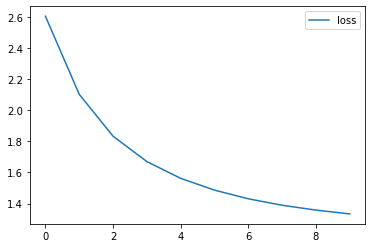

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot()

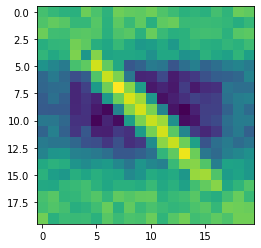

In [ ]:
#The weights are the Markov matrix, and we can show this matrix as an image.
plt.imshow(model.weights[0]);

The first thing you notice is that there is not much structure for the largest and smallest weights.  That is because values above 16 and less than 6 did not occur in the input data (due to the smoothing operation on the artificial data).  The next thing is that where there is structure, this looks like the identity, perhaps "smeared" a bit.  That represents the idea that the likely next state is close to the value of the last state, which is true because the sequence is designed to be at least partly smooth.  So if the network is making a one-step ahead prediction, it is a good idea to predict that things will be close (but perhaps not exactly equal) to the last value.

In [ ]:
#get the model predictions for all timepoints
predicted_outputs = model.predict(generator)  #this is a n_states element vector for each time point
#convert to dataframes with the correct timestamps.  outputs start at t=predict_length
predict_df = pd.DataFrame(data=predicted_outputs)  #14 columns plus the timestamp column
orig_df = pd.DataFrame(data=state_df)


999/999 [==============================] - 2s 2ms/step


Here we compare the timeseries for each of the 10 output probabilities.  The true value is 1 sometimes and 0 most of the time.  The predicted value should be large when the true value is 1, but might be nonzero because there could be other possibilities at that time.

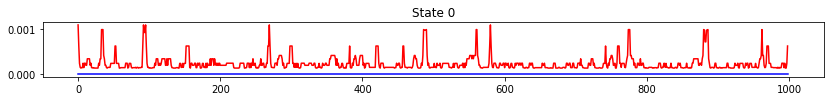

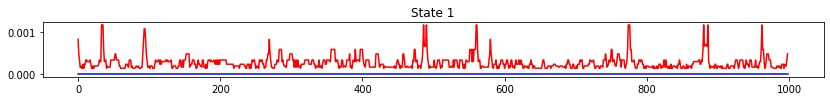

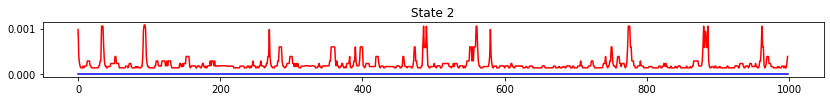

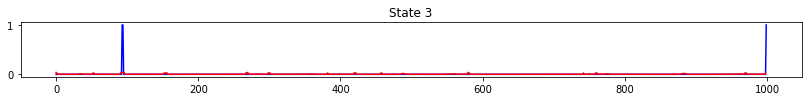

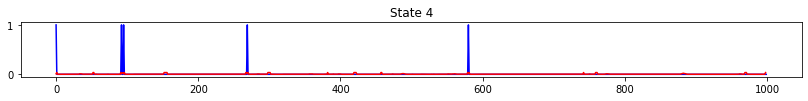

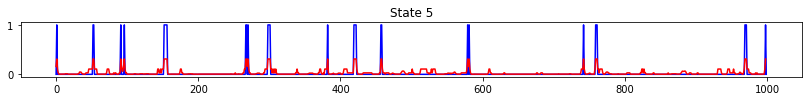

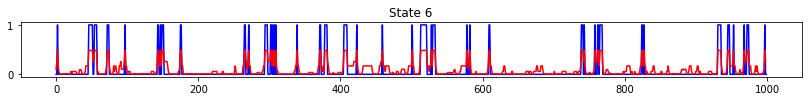

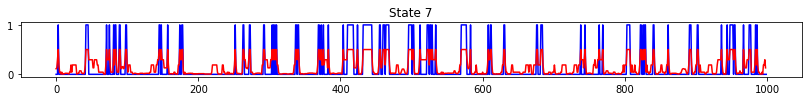

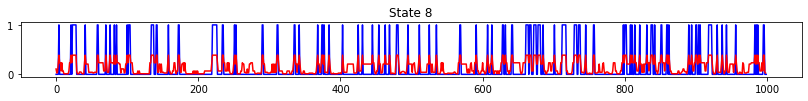

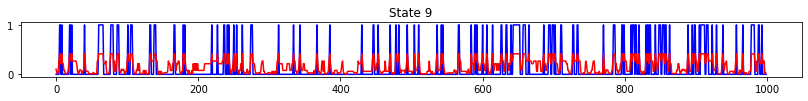

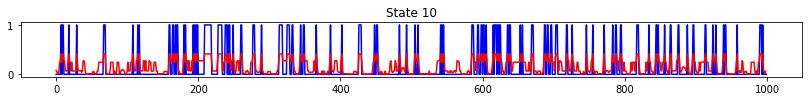

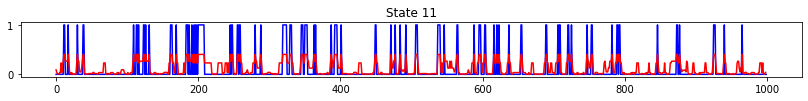

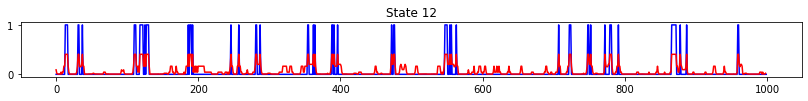

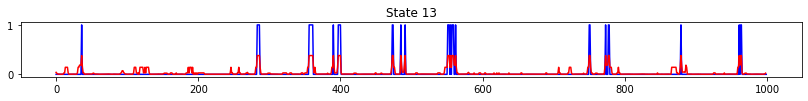

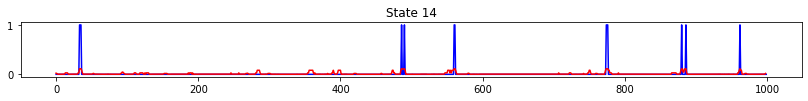

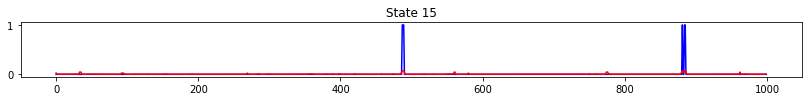

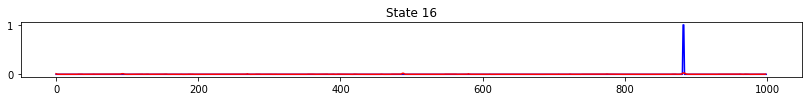

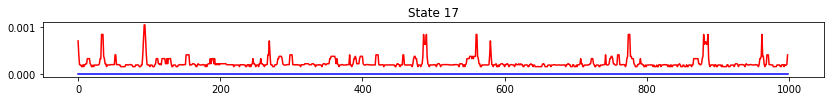

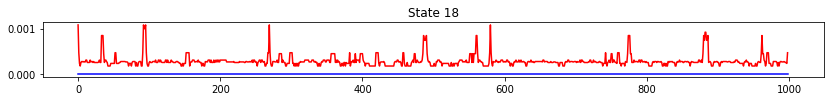

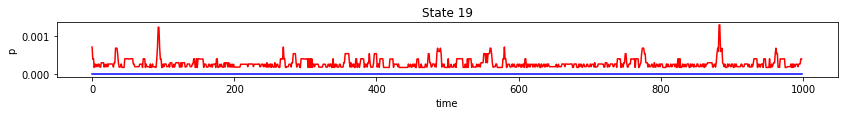

In [ ]:
for n in range(n_states):
  plt.figure(figsize=(14,1),linewidth=.1)
  ax = plt.gca()
  plt.plot(orig_df[n],'b')  #compare one column at a time
  plt.plot(predict_df[n],'r')
  plt.title('State {}'.format(n))
plt.ylabel('p')
plt.xlabel('time');


Because the output is a probability $\hat{p}(t+1)$, we need to extract an estimate of the actual state in order to compare with the true value.  There are two primary ways of doing this:  maximum likelihood (ML) and minimum mean-squared error (MMSE).  ML chooses the value of $i$ with the highest probability ${\rm argmax}_i prob[x(t)=i]$.  MMSE chooses the mean value of $i$, given by $\sum_i i \cdot prob[x(t)=i]$.  

While the ML estimate and the MMSE estimate are often similar, there are important cases where they differ.  Whenever a distribution is skewed in some way, perhaps because there is a bound on the value of $i$ (cannot be less than 0 or greater than 20) the mean will follow the tail of the skew while the maximum will remain at the peak.  If the distribution is multi-lobed, the ML estimate will find the highest peak while the MMSE estimate will tend to find an average position between the peaks.  ML can jump wildly between different peaks with only small changes in relative peak height, while MMSE can predict a value between the peaks that is itself highly unlikely.  So each has problems.  

rms_error ML estimate 16.492422502470642
rms_error MMSE estimate 29.25947950347683


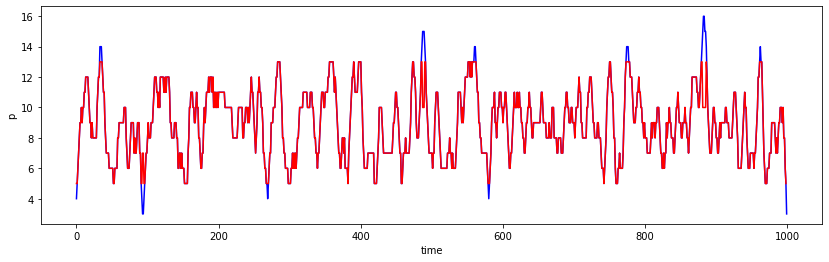

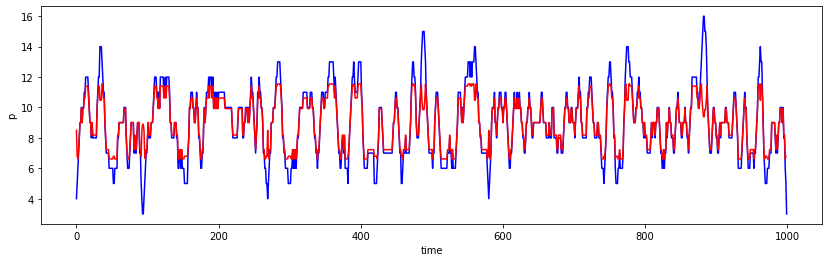

In [ ]:
  orig_ML = orig_df.idxmax(axis=1)
  predict_ML = predict_df.idxmax(axis=1)
  orig_MMSE = orig_df.dot(np.arange(0,20))
  predict_MMSE = predict_df.dot(np.arange(0,20))

  plt.figure(figsize=(14,4),linewidth=.1)
  ax = plt.gca()
  plt.plot(orig_ML,'b')  #compare one column at a time
  plt.plot(predict_ML,'r')
  plt.ylabel('p')
  plt.xlabel('time');

  plt.figure(figsize=(14,4),linewidth=.1)
  ax = plt.gca()
  plt.plot(orig_MMSE,'b')  #compare one column at a time
  plt.plot(predict_MMSE,'r')
  plt.ylabel('p')
  plt.xlabel('time');

rms_error = np.sqrt(np.sum(np.square(orig_ML-predict_ML)))
print('rms_error ML estimate {}'.format(rms_error))
rms_error = np.sqrt(np.sum(np.square(orig_MMSE-predict_MMSE)))
print('rms_error MMSE estimate {}'.format(rms_error))

Note that the ML estimate tends to be better here, because this is essentially a categorical problem and all possible values should be integers.  Also the MMSE estimate seems to be averageing or smoothing in a way that reduces the height of the sudden peaks.

#Model 2: probability input, single output

Here we will use simpleRNN to do the mapping from $p(t)$ to the single output $i(t)$.  In other words, the input is a 20-element probability vector, and the output is a scalar integer indicating the correct value of the state.

When we do this, the network is free to figure out any way it likes to calculate the state value.  To constrain this to be a bit more understandable, we will fix the last (output) layer of the network to have weights which are the numbers from 0...19 (divided by 20 to scale properly for learning) so that if the network correctly creates the probability density $prob[x(t)=i]$ then the result of the last layer of the network will be $\sum_i i \cdot prob[i]$ which is the mean, and thus the MMSE.

We leave the input as the probability density format (a single 1 in the position of the correct state) in order to further force the network to create an internal representation that looks like a probability density.

In [ ]:
predict_length2 = 5
#divide by n_states so input and output run 0...1 which is easier for learning
generator2 = TimeseriesGenerator(state_df.values, state_sequence/n_states, length =predict_length2 , batch_size=1)  #use at least 14 points because 14 dimensions
n_features2 = n_states
n_hidden2 = n_states
model2 = Sequential()
model2.add(SimpleRNN(n_hidden2, activation='softmax', input_shape=(predict_length2, n_features2)))  #feel free to use 'sigmoid' or 'relu' un#feel free to use 'sigmoid' or 'relu' units
model2.add(Dense(1, activation='linear'))   #linear output to estimate the value using MMSE

#fix the last layer to calculate the mean
model2.layers[1].trainable=False    #will not be modified by learning
layer = model2.layers[1]
output_weights = np.array(np.arange(0,n_states)).reshape(n_states,1)/n_states   #0...20 scaled by n_states so the output range is 0...1
layer.set_weights([output_weights, np.zeros(layer.get_weights()[1].shape)])  #set the nontrainable weights.

model2.compile(optimizer='adam', loss='mse')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20)                820       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 841
Trainable params: 820
Non-trainable params: 21
_________________________________________________________________


Epoch 1/10
995/995 [==============================] - 5s 4ms/step - loss: 0.0085
Epoch 2/10
995/995 [==============================] - 4s 4ms/step - loss: 0.0045
Epoch 3/10
995/995 [==============================] - 3s 3ms/step - loss: 0.0033
Epoch 4/10
995/995 [==============================] - 3s 3ms/step - loss: 0.0028
Epoch 5/10
995/995 [==============================] - 3s 3ms/step - loss: 0.0025
Epoch 6/10
995/995 [==============================] - 3s 3ms/step - loss: 0.0024
Epoch 7/10
995/995 [==============================] - 4s 4ms/step - loss: 0.0022
Epoch 8/10
995/995 [==============================] - 3s 3ms/step - loss: 0.0021
Epoch 9/10
995/995 [==============================] - 4s 4ms/step - loss: 0.0021
Epoch 10/10
995/995 [==============================] - 3s 3ms/step - loss: 0.0020


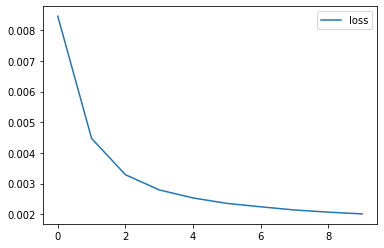

In [ ]:
model2.fit(generator2,epochs=10)
losses = pd.DataFrame(model2.history.history)
losses.plot()

995/995 [==============================] - 2s 2ms/step
rms_error 28.401585225854603


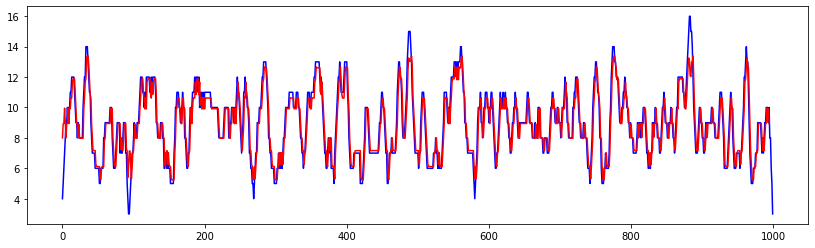

In [ ]:
#get the model predictions for all timepoints
predicted_outputs = n_states * model2.predict(generator2)  #this is a n_states element vector for each time point
#convert to dataframes with the correct timestamps.
predict_df = pd.DataFrame(data=np.append(predicted_outputs[0:predict_length2],predicted_outputs[0:-predict_length2]))
orig_df = pd.DataFrame(data=state_sequence)
plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(orig_df,'b')
plt.plot(predict_df,'r')
#in this case we do not need to calculate the ML or MMSE estimates because the network has a scalar output (close to MMSE)
rms_error = np.sqrt(np.sum(np.square(orig_df[0]-predict_df[0])))
print('rms_error {}'.format(rms_error))

The model is not completely successful at creating a Markov-like matrix structure.  It appears that the network places most of the energy at the left and right ends of the hidden state vector, and then uses the MMSE estimate to average between these.  It is a perfectly good strategy, but not the one we had hoped for.  The moral of the story is that it is very hard to predict how backpropagation will solve a problem.

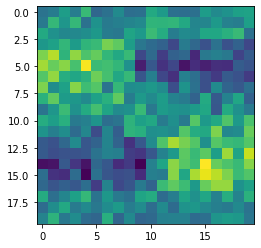

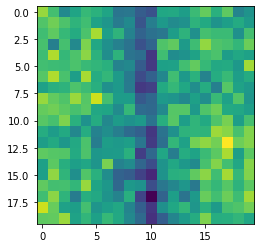

In [ ]:
plt.figure()
plt.imshow(model2.weights[0]);
plt.figure()
plt.imshow(model2.weights[1]);
#model2.weights[1]

#Model 3: probability input and output using cross_entropy for simpleRNN

In models 1 and 2 we cared specifically about matching the particular numerical values of the output, and thus used the mean-squared error loss function.  In fact in model 1 we could have used CategoricalCrossentropy because the output was a category, and in model 2 we could have used SparseCategoricalCrossentropy which is the same thing but when the target output is a single integer rather than a "one-hot" encoding of state.

Here we will use CategoricalCrossentropy directly for training a simpleRNN, where the target output is the probability density and the input is given as a density as well.  The reason to use categorical_crossentropy is that it recognizes that maximum likelihood is probably the right answer.  This is the loss function that goes with softmax; it is not a hard ML estimate, but a somewhat softened ML estimate that nevertheless is strongly influenced by the highest output probabilities.  It is equivalent to MSE on the log probabilities (because the log probabilities add, whereas the exponentiated values multiply), so in most cases the answers are not really that different.  But it's nice to know why to use each function.

The difference between model3 and model1 is that model3 is using a simpleRNN, not just a linear network.  But the answer will be almost the same.  The difference here is that we have predict_length = 5, so the network is learning a transition matrix over a sequence of more than one state, which will not be the same as the Markov transition matrix for a single step.  

In [ ]:
predict_length3 = 5
#same as model1 generator
generator3 = TimeseriesGenerator(state_df.values, state_df.values, length =predict_length3 , batch_size=1)
n_features3 = n_states
n_hidden3 = n_states
model3 = Sequential()
#simpleRNN without an output layer.  we are going to use the output of the last recurrent layer as the network output
model3.add(SimpleRNN(n_hidden3, activation='softmax', input_shape=(predict_length3, n_features3)))
model3.compile(optimizer='adam', loss='categorical_crossentropy')  #cce loss, as discussed.
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 20)                820       
                                                                 
Total params: 820
Trainable params: 820
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
995/995 [==============================] - 4s 3ms/step - loss: 2.5080
Epoch 2/10
995/995 [==============================] - 3s 3ms/step - loss: 2.0002
Epoch 3/10
995/995 [==============================] - 3s 3ms/step - loss: 1.7683
Epoch 4/10
995/995 [==============================] - 3s 3ms/step - loss: 1.6234
Epoch 5/10
995/995 [==============================] - 4s 4ms/step - loss: 1.5247
Epoch 6/10
995/995 [==============================] - 4s 4ms/step - loss: 1.4562
Epoch 7/10
995/995 [==============================] - 4s 4ms/step - loss: 1.4069
Epoch 8/10
995/995 [==============================] - 3s 3ms/step - loss: 1.3717
Epoch 9/10
995/995 [==============================] - 4s 4ms/step - loss: 1.3442
Epoch 10/10
995/995 [==============================] - 4s 4ms/step - loss: 1.3234


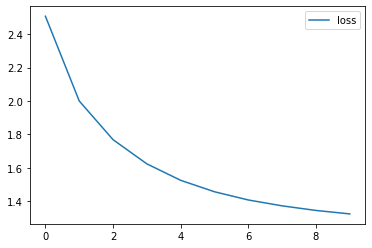

In [ ]:
model3.fit(generator3,epochs=10)
losses = pd.DataFrame(model3.history.history)
losses.plot()

In [ ]:
#get the model predictions for all timepoints
predicted_outputs = model3.predict(generator3)  #this is a n_states element vector for each time point
#convert to dataframes with the correct timestamps.  outputs start at t=predict_length
predict3_df = pd.DataFrame(data=predicted_outputs)  #14 columns plus the timestamp column
orig3_df = pd.DataFrame(data=state_df);


995/995 [==============================] - 3s 3ms/step


Here we once again need to compute the ML and MMSE estimates, because the output of the network is a probability density, not a scalar.

rms_error ML estimate 16.492422502470642
rms_error MMSE estimate 29.25947950347683


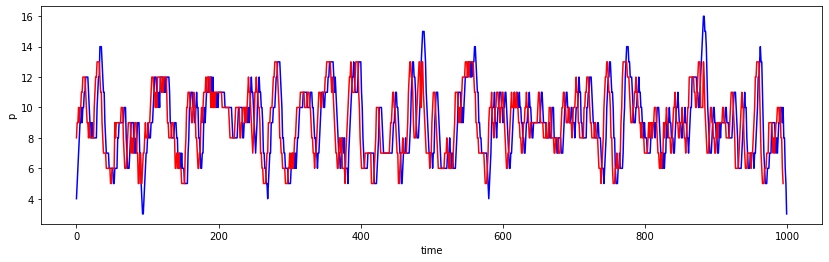

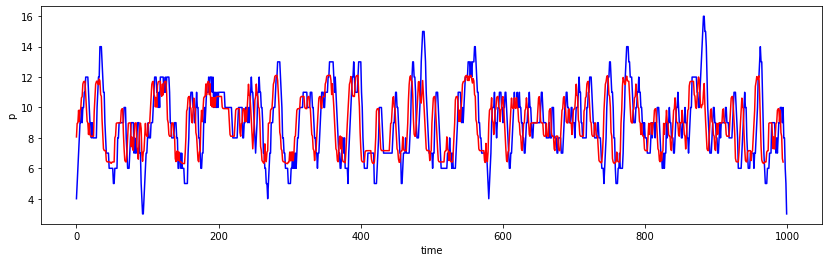

In [ ]:
  orig3_ML = orig3_df.idxmax(axis=1)
  predict3_ML = predict3_df.idxmax(axis=1)
  orig3_MMSE = orig3_df.dot(np.arange(0,20))
  predict3_MMSE = predict3_df.dot(np.arange(0,20))

  plt.figure(figsize=(14,4),linewidth=.1)
  ax = plt.gca()
  plt.plot(orig3_ML,'b')  #compare one column at a time
  plt.plot(predict3_ML,'r')
  plt.ylabel('p')
  plt.xlabel('time');

  plt.figure(figsize=(14,4),linewidth=.1)
  ax = plt.gca()
  plt.plot(orig3_MMSE,'b')  #compare one column at a time
  plt.plot(predict3_MMSE,'r')
  plt.ylabel('p')
  plt.xlabel('time');

  rms_error = np.sqrt(np.sum(np.square(orig_ML-predict_ML)))
  print('rms_error ML estimate {}'.format(rms_error))
  rms_error = np.sqrt(np.sum(np.square(orig_MMSE-predict_MMSE)))
  print('rms_error MMSE estimate {}'.format(rms_error))

The input weights correctly map the input probability density onto the state, so we know that the state representation is the right form of probability.  The output weights are considerably fuzzier, probably because of uncertainty.  But note that one weakness of using categorical cross-entropy for learning is that the network gets it right if the maximum probability is right.  It does not need to care at all about the second highest probability value, so that may not be trained.

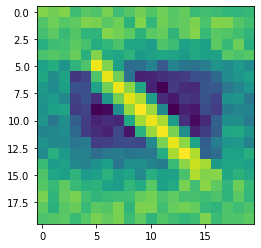

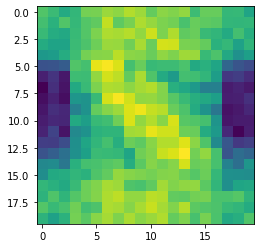

In [ ]:
plt.figure()
plt.imshow(model3.weights[0]);
plt.figure()
plt.imshow(model3.weights[1]);


#Homework 4

1. Create a 1000-point timeseries that is a sinewave that lies within the integers 0...100  (ie:  int(50 + 40 * sin(2pi * t/T), where the period T is 100 timesteps  (this is state_sequence1).  Run model3 on this and show the weight matrices and errors as above.  

**Question1**:  This is a more predictable timeseries than the one above.  What could you do make use of predictability to get better estimates?

2. Create another 1000-point timeseries that is int(50 + 40 * cos(2pi * t/T) (this is state_sequence2) and create a probability distribution so that either could be truth with 60/40% probability.  In other words, there are two possible state sequences happening at the same time, but one has probability of 0.6 and the other has probability of 0.4.  Now run model3 on the combined sequence.  In particular, compare the ML and MMSE estimates.  To generate the network inputs and outputs, use:

state_vec1 = np.zeros((time_points, n_states), dtype = float)

state_vec2 = np.zeros((time_points, n_states), dtype = float)

state_vec1[np.arange(time_points),state_sequence1] = 0.6

state_vec2[np.arange(time_points),state_sequence2] = 0.4

state_vec = np.add(state_vec1,state_vec2)

**Question2**: What happened here?

3. Create a 1000-point timeseries with 200 elements (n_states) at each time, but instead of adding the two sequences from problem 2, include them both in separate regions of the probability vector.  In other words, at each time there is a probability vector where the first 100 elements are a sin wave (as in problem 1) and the second are a cos wave, both of equal strength.  Run model3 again. You can use:

state_vec1 = np.zeros((time_points, n_states), dtype = int)

state_vec2 = np.zeros((time_points, n_states), dtype = int)

state_vec1[np.arange(time_points),state_sequence1] = 1

state_vec2[np.arange(time_points),state_sequence2] = 1

state_vec = np.append(state_vec,state_vec2,axis=1)

**Question3**:   Explain the weight matrices and ML and MMSE estimates.  What is this a model of?


# Question 1:

Create a 1000-point timeseries that is a sinewave that lies within the integers 0...100 (ie: int(50 + 40 * sin(2pi * t/T), where the period T is 100 timesteps (this is state_sequence1). Run model3 on this and show the weight matrices and errors as above.

[50 52 55 57 59 62 64 67 69 71]


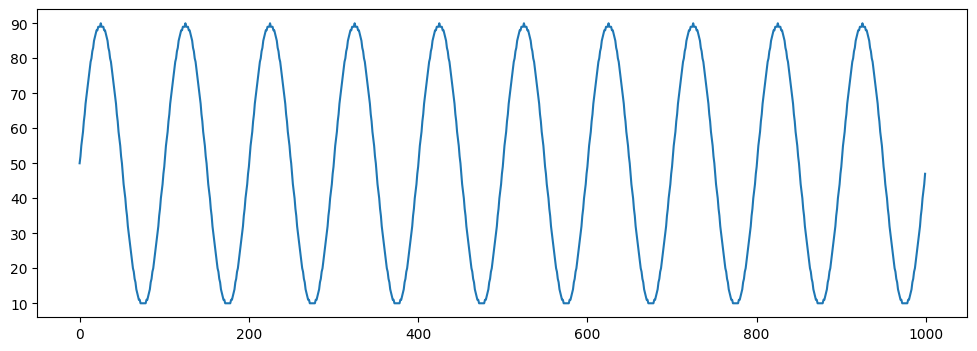

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import tensorflow as tf
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import SimpleRNN

#for your homework
np.random.seed(57999719)
tf.random.set_seed(57999719)

time_points = 1000
t = np.arange(time_points)
state_sequence1 = np.int32(50 + 40 * np.sin(2*np.pi * t/100))
plt.figure(figsize=(12,4), linewidth = 1)
plt.plot(state_sequence1);
print(state_sequence1[0:10])

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

n_states = 91 #90 is highest value and we started at 0
state_vec = np.zeros((time_points, n_states), dtype = int)
state_vec[np.arange(time_points),state_sequence1] = 1
state_vec[0:10,:]

state_df = pd.DataFrame(data=state_vec, index=np.arange(time_points))

predict_length = 1
generator = TimeseriesGenerator(state_df.values, state_df.values, length =predict_length , batch_size=1)  #use at least 14 points because 14 dimensions
#NOTE1:  you have to use df.values or you get weird indexing errors

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 91)             │        16,653 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,653 (65.05 KB)

 Trainable params: 16,653 (65.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.2824
Epoch 2/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.6103
Epoch 3/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.2461
Epoch 4/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.9678
Epoch 5/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.7131
Epoch 6/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.4781
Epoch 7/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.2319
Epoch 8/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.0411
Epoch 9/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.8003
Epoch 10/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6111
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 833us/step


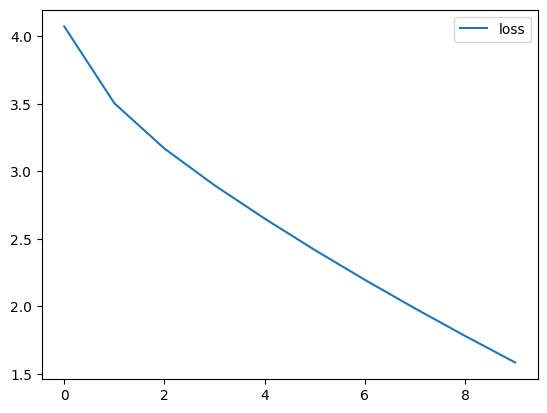

In [ ]:
predict_length3 = 5
#same as model1 generator
generator3 = TimeseriesGenerator(state_df.values, state_df.values, length =predict_length3 , batch_size=1)
n_features3 = n_states
n_hidden3 = n_states
model3 = Sequential()
#simpleRNN without an output layer.  we are going to use the output of the last recurrent layer as the network output
model3.add(SimpleRNN(n_hidden3, activation='softmax', input_shape=(predict_length3, n_features3)))
model3.compile(optimizer='adam', loss='categorical_crossentropy')  #cce loss, as discussed.
model3.summary()

model3.fit(generator3,epochs=10)
losses = pd.DataFrame(model3.history.history)
losses.plot()

#get the model predictions for all timepoints
predicted_outputs = model3.predict(generator3)  #this is a n_states element vector for each time point
#convert to dataframes with the correct timestamps.  outputs start at t=predict_length
predict3_df = pd.DataFrame(data=predicted_outputs)  #14 columns plus the timestamp column
orig3_df = pd.DataFrame(data=state_df);

rms_error ML estimate 239.47860029656096
rms_error MMSE estimate 454.68023890205416


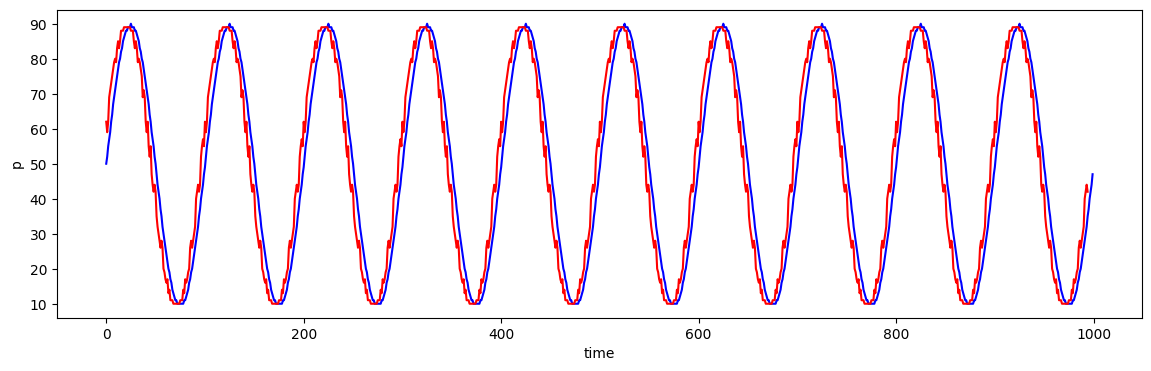

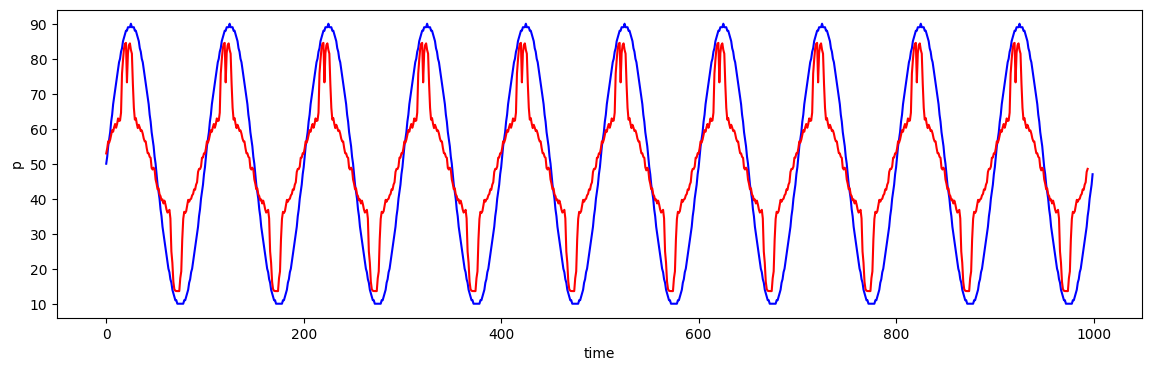

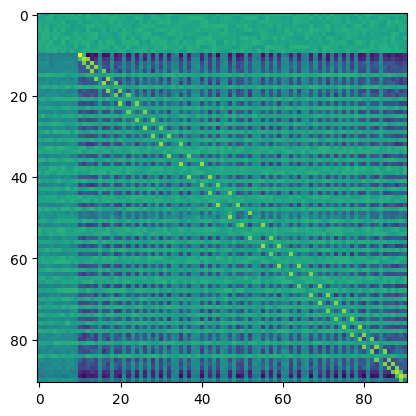

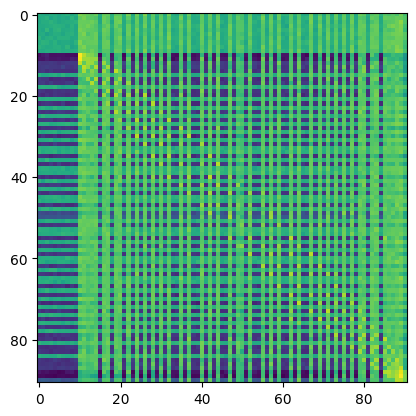

In [ ]:
orig3_ML = orig3_df.idxmax(axis=1)
predict3_ML = predict3_df.idxmax(axis=1)
orig3_MMSE = orig3_df.dot(np.arange(0,91))
predict3_MMSE = predict3_df.dot(np.arange(0,91))

plt.figure(figsize=(14,4),linewidth=.1)
ax = plt.gca()
plt.plot(orig3_ML,'b')  #compare one column at a time
plt.plot(predict3_ML,'r')
plt.ylabel('p')
plt.xlabel('time');

plt.figure(figsize=(14,4),linewidth=.1)
ax = plt.gca()
plt.plot(orig3_MMSE,'b')  #compare one column at a time
plt.plot(predict3_MMSE,'r')
plt.ylabel('p')
plt.xlabel('time');

rms_error = np.sqrt(np.sum(np.square(orig3_ML-predict3_ML)))
print('rms_error ML estimate {}'.format(rms_error))
rms_error = np.sqrt(np.sum(np.square(orig3_MMSE-predict3_MMSE)))
print('rms_error MMSE estimate {}'.format(rms_error))

plt.figure()
plt.imshow(model3.weights[0]);
plt.figure()
plt.imshow(model3.weights[1]);

## Question 2:

Create another 1000-point timeseries that is int(50 + 40 * cos(2pi * t/T) (this is state_sequence2) and create a probability distribution so that either could be truth with 60/40% probability. In other words, there are two possible state sequences happening at the same time, but one has probability of 0.6 and the other has probability of 0.4. Now run model3 on the combined sequence. In particular, compare the ML and MMSE estimates. To generate the network inputs and outputs, use:

[50 52 55 57 59 62 64 67 69 71]
[90 89 89 89 88 88 87 86 85 83]


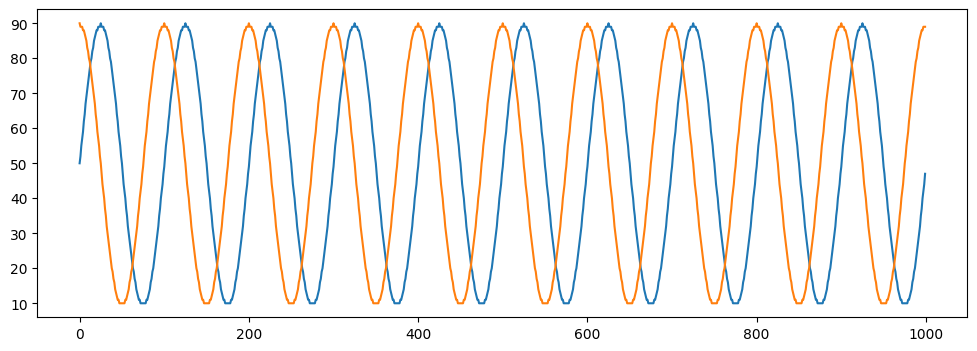

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import tensorflow as tf
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import SimpleRNN

#for your homework
np.random.seed(57999719)
tf.random.set_seed(57999719)

time_points = 1000
t = np.arange(time_points)
state_sequence1 = np.int32(50 + 40 * np.sin(2*np.pi * t/100))
state_sequence2 = np.int32(50 + 40 * np.cos(2*np.pi * t/100))
plt.figure(figsize=(12,4), linewidth = 1)
plt.plot(state_sequence1);
plt.plot(state_sequence2);
print(state_sequence1[0:10])
print(state_sequence2[0:10])

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
n_states = 91 #90 is highest value and we started at 0
state_vec1 = np.zeros((time_points, n_states), dtype = float)
state_vec2 = np.zeros((time_points, n_states), dtype = float)

state_vec1[np.arange(time_points),state_sequence1] = 0.6
state_vec2[np.arange(time_points),state_sequence2] = 0.4
state_vec = np.add(state_vec1,state_vec2)

state_vec[0:10,:]
state_df = pd.DataFrame(data=state_vec, index=np.arange(time_points))
predict_length = 1
generator = TimeseriesGenerator(state_df.values, state_df.values, length =predict_length , batch_size=1)  #use at least 14 points because 14 dimensions
#NOTE1:  you have to use df.values or you get weird indexing errors

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 91)             │        16,653 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,653 (65.05 KB)

 Trainable params: 16,653 (65.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.2527
Epoch 2/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.5471
Epoch 3/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.1800
Epoch 4/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.9275
Epoch 5/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.6577
Epoch 6/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.4565
Epoch 7/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.2590
Epoch 8/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.1027
Epoch 9/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.9266
Epoch 10/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7957
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step


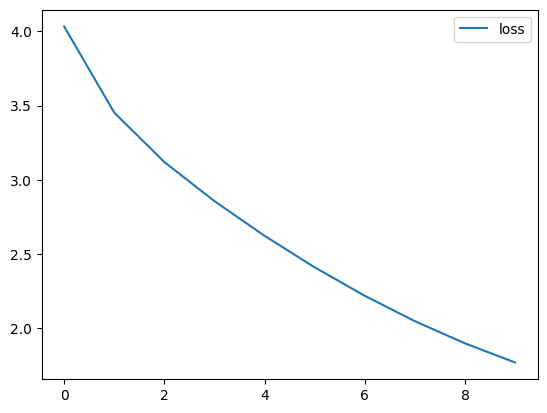

In [ ]:
predict_length3 = 5
#same as model1 generator
generator3 = TimeseriesGenerator(state_df.values, state_df.values, length =predict_length3 , batch_size=1)
n_features3 = n_states
n_hidden3 = n_states
model3 = Sequential()
#simpleRNN without an output layer.  we are going to use the output of the last recurrent layer as the network output
model3.add(SimpleRNN(n_hidden3, activation='softmax', input_shape=(predict_length3, n_features3)))
model3.compile(optimizer='adam', loss='categorical_crossentropy')  #cce loss, as discussed.
model3.summary()

model3.fit(generator3,epochs=10)
losses = pd.DataFrame(model3.history.history)
losses.plot()

#get the model predictions for all timepoints
predicted_outputs = model3.predict(generator3)  #this is a n_states element vector for each time point
#convert to dataframes with the correct timestamps.  outputs start at t=predict_length
predict3_df = pd.DataFrame(data=predicted_outputs)  #14 columns plus the timestamp column
orig3_df = pd.DataFrame(data=state_df);


rms_error ML estimate 239.47860029656096
rms_error MMSE estimate 454.68023890205416


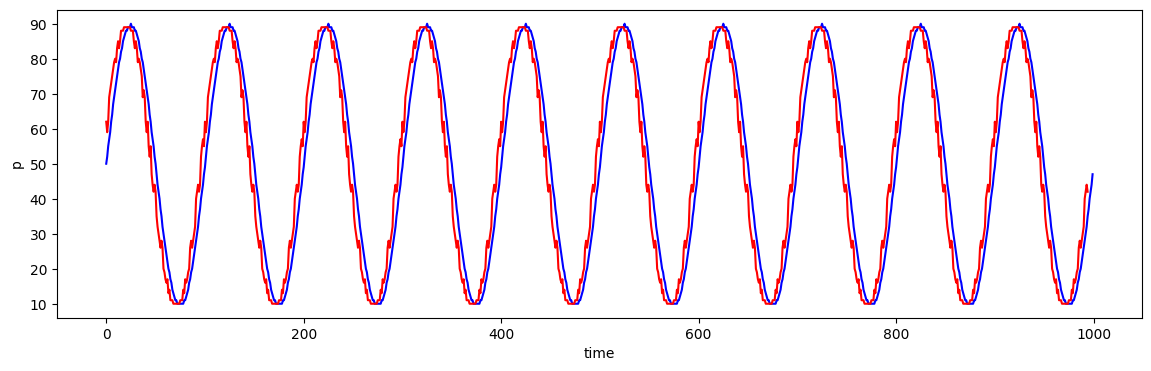

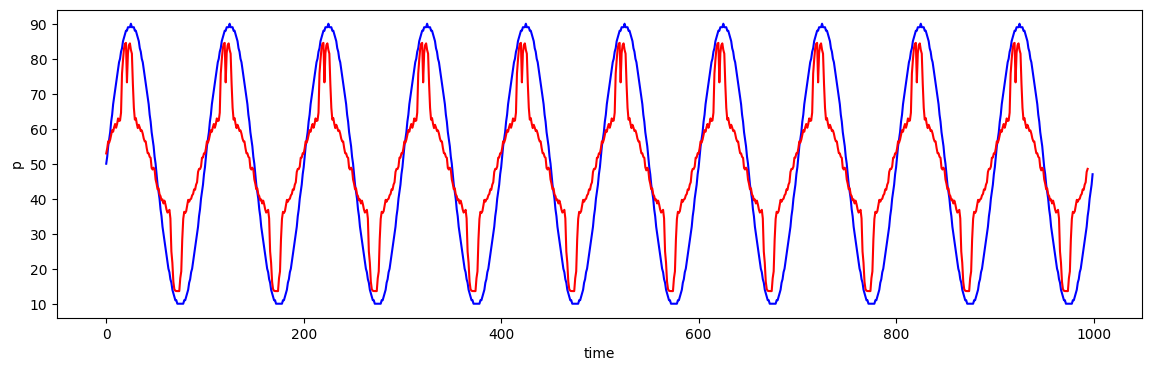

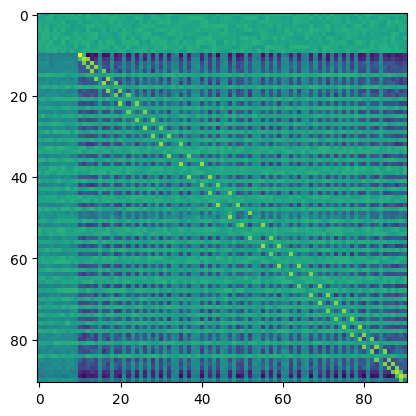

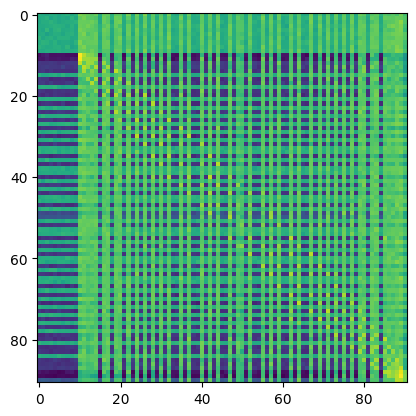

In [ ]:
orig3_ML = orig3_df.idxmax(axis=1)
predict3_ML = predict3_df.idxmax(axis=1)
orig3_MMSE = orig3_df.dot(np.arange(0,91))
predict3_MMSE = predict3_df.dot(np.arange(0,91))

plt.figure(figsize=(14,4),linewidth=.1)
ax = plt.gca()
plt.plot(orig3_ML,'b')  #compare one column at a time
plt.plot(predict3_ML,'r')
plt.ylabel('p')
plt.xlabel('time');

plt.figure(figsize=(14,4),linewidth=.1)
ax = plt.gca()
plt.plot(orig3_MMSE,'b')  #compare one column at a time
plt.plot(predict3_MMSE,'r')
plt.ylabel('p')
plt.xlabel('time');

rms_error = np.sqrt(np.sum(np.square(orig3_ML-predict3_ML)))
print('rms_error ML estimate {}'.format(rms_error))
rms_error = np.sqrt(np.sum(np.square(orig3_MMSE-predict3_MMSE)))
print('rms_error MMSE estimate {}'.format(rms_error))

plt.figure()
plt.imshow(model3.weights[0]);
plt.figure()
plt.imshow(model3.weights[1]);

# Question 3:

Create a 1000-point timeseries with 200 elements (n_states) at each time, but instead of adding the two sequences from problem 2, include them both in separate regions of the probability vector. In other words, at each time there is a probability vector where the first 100 elements are a sin wave (as in problem 1) and the second are a cos wave, both of equal strength. Run model3 again. You can use:


[50 52 55 57 59 62 64 67 69 71]
[90 89 89 89 88 88 87 86 85 83]


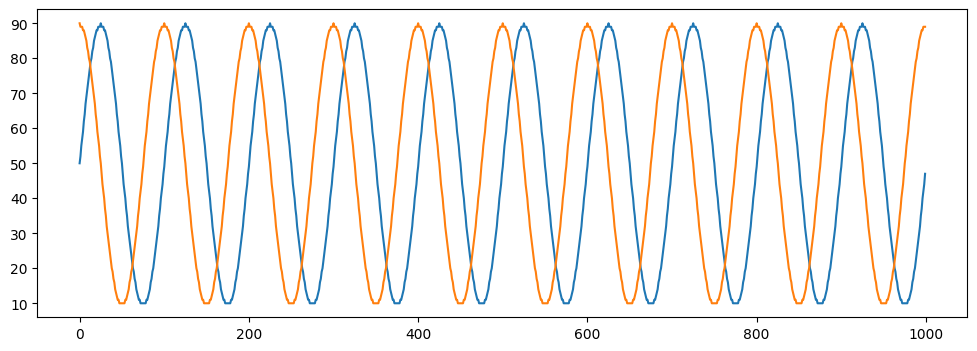

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import tensorflow as tf
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import SimpleRNN

#for your homework
np.random.seed(57999719)
tf.random.set_seed(57999719)

time_points = 1000
t = np.arange(time_points)
state_sequence1 = np.int32(50 + 40 * np.sin(2*np.pi * t/100))
state_sequence2 = np.int32(50 + 40 * np.cos(2*np.pi * t/100))
plt.figure(figsize=(12,4), linewidth = 1)
plt.plot(state_sequence1);
plt.plot(state_sequence2);
print(state_sequence1[0:10])
print(state_sequence2[0:10])

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
n_states = 91
state_vec1 = np.zeros((time_points, n_states), dtype = int)
state_vec2 = np.zeros((time_points, n_states), dtype = int)
#now the type is int whereas for q2 it was float

state_vec1[np.arange(time_points),state_sequence1] = 1
state_vec2[np.arange(time_points),state_sequence2] = 1
# Initialize state_vec before appending
state_vec = np.zeros((time_points, 2 * n_states), dtype = int)
state_vec[:, :n_states] = state_vec1
state_vec[:, n_states:] = state_vec2
#instead of adding we are appending the two into the
#same array so they don't overlap.

state_vec[0:10,:]
state_df = pd.DataFrame(data=state_vec, index=np.arange(time_points))
predict_length = 1
generator = TimeseriesGenerator(state_df.values, state_df.values, length =predict_length , batch_size=1)  #use at least 14 points because 14 dimensions
#NOTE1:  you have to use df.values or you get weird indexing errors

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_21 (SimpleRNN)       │ (None, 182)            │        66,430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,430 (259.49 KB)

 Trainable params: 66,430 (259.49 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.8536
Epoch 2/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.0385
Epoch 3/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.8720
Epoch 4/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.9154
Epoch 5/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.0729
Epoch 6/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.3069
Epoch 7/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.6035
Epoch 8/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.0273
Epoch 9/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.5776
Epoch 10/10
995/995 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2312
995/995 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step


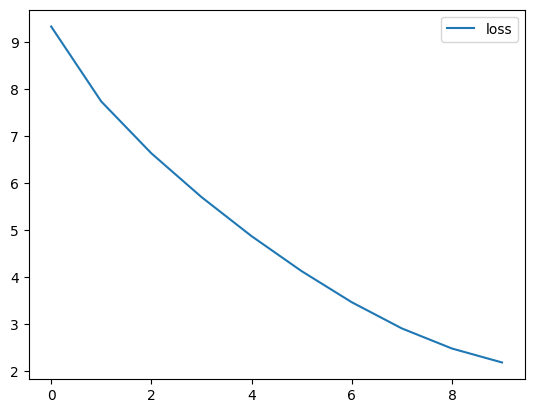

In [ ]:
predict_length3 = 5
#same as model1 generator
generator3 = TimeseriesGenerator(state_df.values, state_df.values, length =predict_length3 , batch_size=1)
n_features3 = 2*n_states
n_hidden3 = 2*n_states
model3 = Sequential()
#simpleRNN without an output layer.  we are going to use the output of the last recurrent layer as the network output
model3.add(SimpleRNN(n_hidden3, activation='softmax', input_shape=(predict_length3, n_features3)))
model3.compile(optimizer='adam', loss='categorical_crossentropy')  #cce loss, as discussed.
model3.summary()

model3.fit(generator3,epochs=10)
losses = pd.DataFrame(model3.history.history)
losses.plot()

#get the model predictions for all timepoints
predicted_outputs = model3.predict(generator3)  #this is a n_states element vector for each time point
#convert to dataframes with the correct timestamps.  outputs start at t=predict_length
predict3_df = pd.DataFrame(data=predicted_outputs)  #14 columns plus the timestamp column
orig3_df = pd.DataFrame(data=state_df);


rms_error ML estimate 2285.338268178258
rms_error MMSE estimate 3102.400902182377


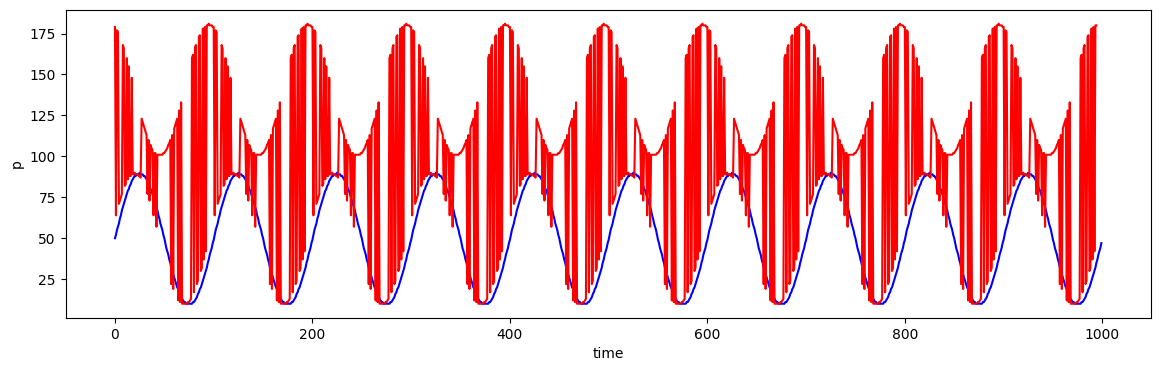

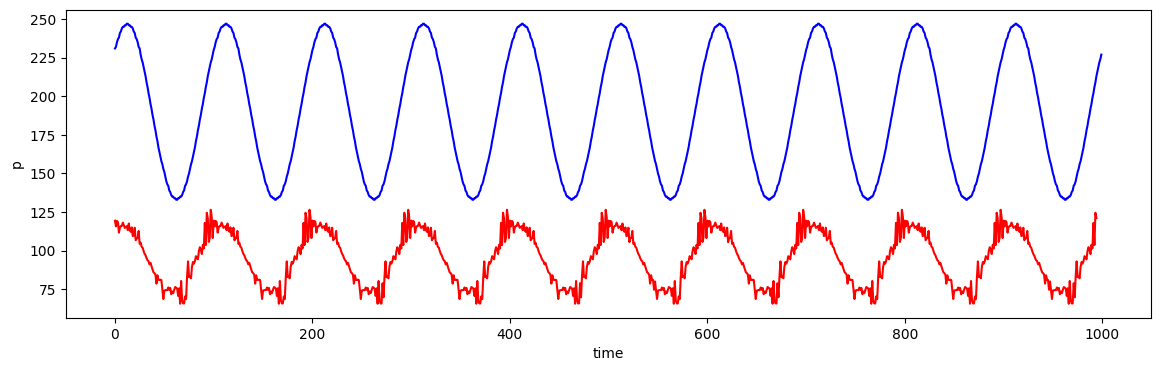

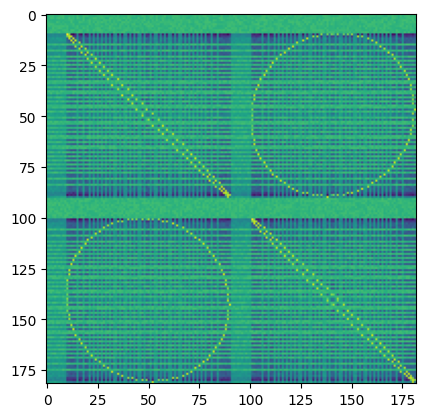

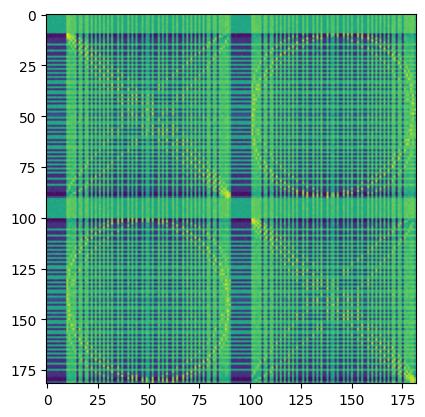

In [ ]:
orig3_ML = orig3_df.idxmax(axis=1)
predict3_ML = predict3_df.idxmax(axis=1)
orig3_MMSE = orig3_df.dot(np.arange(0,182))
predict3_MMSE = predict3_df.dot(np.arange(0,182))

plt.figure(figsize=(14,4),linewidth=.1)
ax = plt.gca()
plt.plot(orig3_ML,'b')  #compare one column at a time
plt.plot(predict3_ML,'r')
plt.ylabel('p')
plt.xlabel('time');

plt.figure(figsize=(14,4),linewidth=.1)
ax = plt.gca()
plt.plot(orig3_MMSE,'b')  #compare one column at a time
plt.plot(predict3_MMSE,'r')
plt.ylabel('p')
plt.xlabel('time');

rms_error = np.sqrt(np.sum(np.square(orig3_ML-predict3_ML)))
print('rms_error ML estimate {}'.format(rms_error))
rms_error = np.sqrt(np.sum(np.square(orig3_MMSE-predict3_MMSE)))
print('rms_error MMSE estimate {}'.format(rms_error))

plt.figure()
plt.imshow(model3.weights[0]);
plt.figure()
plt.imshow(model3.weights[1]);